# Name: Oscar Alonso
# Assignment: Final Project

- I plan to predict the All-NBA teams for the 2022 season.
- All-NBA teams are made up of three 5-man lineups that include 2 guards, 2 centers, and 1 center.
- I plan to use classification techniques to try and predict the 2022 All-NBA teams.
- I am not sure when the All-NBA teams will be released for the 2022 season so it'll be fun to see how right/wrong I am!
- I will use [Dribble Analytic's work](https://github.com/dribbleanalytics/ml-all-nba-predict/blob/master/2018-19/python-master-ml-all-nba-predict.ipynb) as a reference.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Data Collection
- I will use Dribble Analytic's historical dataset that ranges from 1979-80 (3 point era) to 2018 as training and test sets
- I will use the 2021-2022 season to make predictions
    - Will only use the top 75 players based on Win Share advance stat and more than 1/3 of games played

# Importing and cleaning data

In [2]:
### importing datasets ###

# historical dataset
df_historical = pd.read_csv('https://raw.githubusercontent.com/dribbleanalytics/ml-all-nba-predict/master/2018-19/final-csv-data/historical-all-nba.csv')

# points per game 2022 season dataset
df_2022 = pd.read_csv('2022_pg.csv')

# advance stats 2022 season dataset
df_2022_adv = pd.read_csv('2022_adv_stats.csv')

# standings 2022 season dataset
df_2022_stands = pd.read_csv('2022_standings.csv')


print(str(df_historical.shape) + ': shape of historical dataset')
print(str(df_2022.shape) + str(df_2022_adv.shape) + ': shape of ppg and adv datasets')
print(str(df_2022_stands.shape) + ': shape of the NBA standings')

(956, 20): shape of historical dataset
(812, 29)(812, 28): shape of ppg and adv datasets
(30, 3): shape of the NBA standings


In [3]:
df_historical.head()

,Player,Tm,G,Team Wins,Overall Seed,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,All-NBA,All-Star
0,George Gervin,SAS,78.0,41.0,10,37.6,33.1,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,3.1,2.2,1,1
1,Eddie Johnson,ATL,79.0,50.0,6,33.2,18.5,2.5,4.7,1.5,0.3,0.487,0.385,0.828,8.2,0.150,2.8,2.2,0,1
2,Moses Malone,HOU,82.0,41.0,9,38.3,25.8,14.5,1.8,1.0,1.3,0.502,0.000,0.719,11.9,0.183,3.8,2.8,1,1
3,Julius Erving,PHI,78.0,59.0,3,36.1,26.9,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,6.5,7.2,1,1
4,John Drew,ATL,80.0,50.0,6,28.8,19.5,5.9,1.3,1.1,0.3,0.453,0.000,0.757,6.4,0.134,0.8,-0.7,0,1


- I want to make the 2022 season data to look exactly like this historical dataframe ↑

In [4]:
df_2022.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa\achiupr01,C,22,TOR,73,28,23.6,3.6,8.3,0.439,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,Steven Adams\adamsst01,C,28,MEM,76,75,26.3,2.8,5.1,0.547,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,Bam Adebayo\adebaba01,C,24,MIA,56,56,32.6,7.3,13.0,0.557,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,Santi Aldama\aldamsa01,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,LaMarcus Aldridge\aldrila01,C,36,BRK,47,12,22.3,5.4,9.7,0.550,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9


In [5]:
df_2022_adv.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,Unnamed: 18,OWS,DWS,WS,WS/48,Unnamed: 23,OBPM,DBPM,BPM,VORP
0,Precious Achiuwa\achiupr01,C,22,TOR,73,1725,12.7,0.503,0.259,0.217,...,NaN,0.4,2.1,2.5,0.070,NaN,-2.0,-0.6,-2.6,-0.2
1,Steven Adams\adamsst01,C,28,MEM,76,1999,17.6,0.560,0.003,0.518,...,NaN,3.8,3.0,6.8,0.163,NaN,1.0,1.0,2.0,2.0
2,Bam Adebayo\adebaba01,C,24,MIA,56,1825,21.8,0.608,0.008,0.466,...,NaN,3.6,3.5,7.2,0.188,NaN,1.7,2.1,3.8,2.7
3,Santi Aldama\aldamsa01,PF,21,MEM,32,360,10.2,0.452,0.364,0.242,...,NaN,-0.1,0.4,0.3,0.044,NaN,-4.2,-1.5,-5.7,-0.3
4,LaMarcus Aldridge\aldrila01,C,36,BRK,47,1050,19.6,0.604,0.100,0.223,...,NaN,2.1,1.0,3.1,0.141,NaN,1.3,-0.6,0.7,0.7


In [6]:
df_2022_stands.head()

,Tm,Team Wins,Overall Seed
0,PHO,64,1
1,MEM,56,2
2,GSW,53,3
3,MIA,53,1
4,DAL,52,4


In [7]:
# merging ppg and advance stats to make it look like historical dataset
df_2022 = df_2022.merge(df_2022_adv, on='Player')
df_2022.head()

,Player,Pos_x,Age_x,Tm_x,G_x,GS,MP_x,FG,FGA,FG%,...,Unnamed: 18,OWS,DWS,WS,WS/48,Unnamed: 23,OBPM,DBPM,BPM,VORP
0,Precious Achiuwa\achiupr01,C,22,TOR,73,28,23.6,3.6,8.3,0.439,...,NaN,0.4,2.1,2.5,0.070,NaN,-2.0,-0.6,-2.6,-0.2
1,Steven Adams\adamsst01,C,28,MEM,76,75,26.3,2.8,5.1,0.547,...,NaN,3.8,3.0,6.8,0.163,NaN,1.0,1.0,2.0,2.0
2,Bam Adebayo\adebaba01,C,24,MIA,56,56,32.6,7.3,13.0,0.557,...,NaN,3.6,3.5,7.2,0.188,NaN,1.7,2.1,3.8,2.7
3,Santi Aldama\aldamsa01,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,...,NaN,-0.1,0.4,0.3,0.044,NaN,-4.2,-1.5,-5.7,-0.3
4,LaMarcus Aldridge\aldrila01,C,36,BRK,47,12,22.3,5.4,9.7,0.550,...,NaN,2.1,1.0,3.1,0.141,NaN,1.3,-0.6,0.7,0.7


In [8]:
# obtaining our desired columns
df_2022 = df_2022[['Player', 'Tm_x', 'G_x', 'MP_x', 'PTS', 'TRB',
       'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'VORP', 'BPM']]

In [9]:
# now the 2022 looks like historical, just need add team wins, overall seed, all-star
df_2022.head()

,Player,Tm_x,G_x,MP_x,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM
0,Precious Achiuwa\achiupr01,TOR,73,23.6,9.1,6.5,1.1,0.5,0.6,0.439,0.359,0.595,2.5,0.070,-0.2,-2.6
1,Steven Adams\adamsst01,MEM,76,26.3,6.9,10.0,3.4,0.9,0.8,0.547,0.000,0.543,6.8,0.163,2.0,2.0
2,Bam Adebayo\adebaba01,MIA,56,32.6,19.1,10.1,3.4,1.4,0.8,0.557,0.000,0.753,7.2,0.188,2.7,3.8
3,Santi Aldama\aldamsa01,MEM,32,11.3,4.1,2.7,0.7,0.2,0.3,0.402,0.125,0.625,0.3,0.044,-0.3,-5.7
4,LaMarcus Aldridge\aldrila01,BRK,47,22.3,12.9,5.5,0.9,0.3,1.0,0.550,0.304,0.873,3.1,0.141,0.7,0.7


In [10]:
# going to have to account for trades bc TOT isn't a team
df_2022['Tm_x'].unique()

array(['TOR', 'MEM', 'MIA', 'BRK', 'TOT', 'NOP', 'UTA', 'MIL', 'CLE',
       'IND', 'LAL', 'ORL', 'NYK', 'HOU', 'WAS', 'PHO', 'SAC', 'DET',
       'CHO', 'CHI', 'ATL', 'DEN', 'PHI', 'SAS', 'LAC', 'OKC', 'MIN',
       'DAL', 'GSW', 'POR', 'BOS'], dtype=object)

- There is an extra team, 'TOT'
    - That is basketball reference's way of accounting for players who switched teams throughout the season

In [11]:
# these are the players that got traded/switched teams
df_2022[df_2022['Tm_x'] == 'TOT'].Player.unique()

array(['Nickeil Alexander-Walker\\alexani01',
       'Justin Anderson\\anderju01', 'D.J. Augustin\\augusdj01',
       'Marvin Bagley III\\baglema01', "DeAndre' Bembry\\bembrde01",
       'Dāvis Bertāns\\bertada01', 'Armoni Brooks\\brookar01',
       'Charlie Brown Jr.\\brownch02', 'Chaundee Brown Jr.\\brownch05',
       'Moses Brown\\brownmo01', 'Vernon Carey Jr.\\careyve01',
       'Jevon Carter\\carteje01', 'Willie Cauley-Stein\\caulewi01',
       'DeMarcus Cousins\\couside01', 'Robert Covington\\covinro01',
       'Torrey Craig\\craigto01', 'Seth Curry\\curryse01',
       'Spencer Dinwiddie\\dinwisp01', 'Donte DiVincenzo\\divindo01',
       'Jeff Dowtin\\dowtije01', 'Goran Dragić\\dragigo01',
       'Andre Drummond\\drumman01', 'James Ennis III\\ennisja01',
       'Drew Eubanks\\eubandr01', 'Bruno Fernando\\fernabr01',
       'Malik Fitts\\fittsma01', 'Bryn Forbes\\forbebr01',
       'Tim Frazier\\fraziti01', 'Wenyen Gabriel\\gabriwe01',
       'Langston Galloway\\gallola01', 'Tyres

In [12]:
df_2022.columns

Index(['Player', 'Tm_x', 'G_x', 'MP_x', 'PTS', 'TRB', 'AST', 'STL', 'BLK',
       'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'VORP', 'BPM'],
      dtype='object')

In [13]:
df_historical.columns

Index(['Player', 'Tm', 'G', 'Team Wins', 'Overall Seed', 'MP', 'PTS', 'TRB',
       'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'VORP', 'BPM',
       'All-NBA', 'All-Star'],
      dtype='object')

In [14]:
# renaming columns to make them look like historical
df_2022.rename(columns={"Tm_x": "Tm", 'G_x': 'G', 'MP_x': 'MP'}, inplace=True)

In [15]:
df_2022.head()

,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM
0,Precious Achiuwa\achiupr01,TOR,73,23.6,9.1,6.5,1.1,0.5,0.6,0.439,0.359,0.595,2.5,0.070,-0.2,-2.6
1,Steven Adams\adamsst01,MEM,76,26.3,6.9,10.0,3.4,0.9,0.8,0.547,0.000,0.543,6.8,0.163,2.0,2.0
2,Bam Adebayo\adebaba01,MIA,56,32.6,19.1,10.1,3.4,1.4,0.8,0.557,0.000,0.753,7.2,0.188,2.7,3.8
3,Santi Aldama\aldamsa01,MEM,32,11.3,4.1,2.7,0.7,0.2,0.3,0.402,0.125,0.625,0.3,0.044,-0.3,-5.7
4,LaMarcus Aldridge\aldrila01,BRK,47,22.3,12.9,5.5,0.9,0.3,1.0,0.550,0.304,0.873,3.1,0.141,0.7,0.7


In [16]:
# merging standings with df_2022
df_2022 = df_2022.merge(df_2022_stands,how='left', on='Tm')
df_2022.head()

,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,Team Wins,Overall Seed
0,Precious Achiuwa\achiupr01,TOR,73,23.6,9.1,6.5,1.1,0.5,0.6,0.439,0.359,0.595,2.5,0.070,-0.2,-2.6,48.0,5.0
1,Steven Adams\adamsst01,MEM,76,26.3,6.9,10.0,3.4,0.9,0.8,0.547,0.000,0.543,6.8,0.163,2.0,2.0,56.0,2.0
2,Bam Adebayo\adebaba01,MIA,56,32.6,19.1,10.1,3.4,1.4,0.8,0.557,0.000,0.753,7.2,0.188,2.7,3.8,53.0,1.0
3,Santi Aldama\aldamsa01,MEM,32,11.3,4.1,2.7,0.7,0.2,0.3,0.402,0.125,0.625,0.3,0.044,-0.3,-5.7,56.0,2.0
4,LaMarcus Aldridge\aldrila01,BRK,47,22.3,12.9,5.5,0.9,0.3,1.0,0.550,0.304,0.873,3.1,0.141,0.7,0.7,44.0,7.0


In [17]:
# there seems to be multiple players
df_2022.head(20)

,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,Team Wins,Overall Seed
0,Precious Achiuwa\achiupr01,TOR,73,23.6,9.1,6.5,1.1,0.5,0.6,0.439,0.359,0.595,2.5,0.070,-0.2,-2.6,48.0,5.0
1,Steven Adams\adamsst01,MEM,76,26.3,6.9,10.0,3.4,0.9,0.8,0.547,0.000,0.543,6.8,0.163,2.0,2.0,56.0,2.0
2,Bam Adebayo\adebaba01,MIA,56,32.6,19.1,10.1,3.4,1.4,0.8,0.557,0.000,0.753,7.2,0.188,2.7,3.8,53.0,1.0
3,Santi Aldama\aldamsa01,MEM,32,11.3,4.1,2.7,0.7,0.2,0.3,0.402,0.125,0.625,0.3,0.044,-0.3,-5.7,56.0,2.0
4,LaMarcus Aldridge\aldrila01,BRK,47,22.3,12.9,5.5,0.9,0.3,1.0,0.550,0.304,0.873,3.1,0.141,0.7,0.7,44.0,7.0
5,Nickeil Alexander-Walker\alexani01,TOT,65,22.6,10.6,2.9,2.4,0.7,0.4,0.372,0.311,0.743,0.1,0.003,-0.3,-2.9,NaN,NaN
6,Nickeil Alexander-Walker\alexani01,TOT,65,22.6,10.6,2.9,2.4,0.7,0.4,0.372,0.311,0.743,-0.1,-0.005,-0.3,-3.0,NaN,NaN
7,Nickeil Alexander-Walker\alexani01,TOT,65,22.6,10.6,2.9,2.4,0.7,0.4,0.372,0.311,0.743,0.2,0.070,0.0,-1.7,NaN,NaN
8,Nickeil Alexander-Walker\alexani01,NOP,50,26.3,12.8,3.3,2.8,0.8,0.4,0.375,0.311,0.722,0.1,0.003,-0.3,-2.9,36.0,9.0
9,Nickeil Alexander-Walker\alexani01,NOP,50,26.3,12.8,3.3,2.8,0.8,0.4,0.375,0.311,0.722,-0.1,-0.005,-0.3,-3.0,36.0,9.0


In [18]:
df_2022.shape

(1474, 18)

In [19]:
df_2022.head()

,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,Team Wins,Overall Seed
0,Precious Achiuwa\achiupr01,TOR,73,23.6,9.1,6.5,1.1,0.5,0.6,0.439,0.359,0.595,2.5,0.070,-0.2,-2.6,48.0,5.0
1,Steven Adams\adamsst01,MEM,76,26.3,6.9,10.0,3.4,0.9,0.8,0.547,0.000,0.543,6.8,0.163,2.0,2.0,56.0,2.0
2,Bam Adebayo\adebaba01,MIA,56,32.6,19.1,10.1,3.4,1.4,0.8,0.557,0.000,0.753,7.2,0.188,2.7,3.8,53.0,1.0
3,Santi Aldama\aldamsa01,MEM,32,11.3,4.1,2.7,0.7,0.2,0.3,0.402,0.125,0.625,0.3,0.044,-0.3,-5.7,56.0,2.0
4,LaMarcus Aldridge\aldrila01,BRK,47,22.3,12.9,5.5,0.9,0.3,1.0,0.550,0.304,0.873,3.1,0.141,0.7,0.7,44.0,7.0


In [20]:
# finding 50th percentile range for data cut-off
df_2022['WS'].describe()

count    1474.000000
mean        1.311669
std         1.970740
min        -1.600000
25%         0.000000
50%         0.500000
75%         1.900000
max        15.200000
Name: WS, dtype: float64

In [21]:
df_2022[df_2022['WS'] == 0.5]

,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,Team Wins,Overall Seed
112,Ignas Brazdeikis\brazdig01,ORL,42,12.8,5.0,1.7,0.9,0.2,0.1,0.431,0.310,0.656,0.5,0.041,-0.3,-4.3,22.0,15.0
167,Devontae Cacok\cacokde01,SAS,15,8.1,3.1,2.8,0.4,0.5,0.5,0.677,NaN,0.571,0.5,0.206,0.2,4.2,34.0,10.0
218,Tyler Cook\cookty01,CHI,20,10.0,3.4,2.7,0.2,0.2,0.2,0.605,NaN,0.656,0.5,0.127,-0.1,-4.1,46.0,6.0
263,Ed Davis\davised01,CLE,31,6.5,0.9,2.1,0.2,0.1,0.3,0.688,NaN,0.429,0.5,0.126,0.0,-1.8,44.0,8.0
264,Terence Davis\daviste02,SAC,30,17.9,10.4,3.1,1.3,0.8,0.4,0.423,0.329,0.818,0.5,0.044,0.2,-0.9,30.0,12.0
446,Usman Garuba\garubus01,HOU,24,10.0,2.0,3.5,0.7,0.4,0.5,0.432,0.250,0.714,0.5,0.105,0.1,-0.9,20.0,15.0
495,Maurice Harkless\harklma01,SAC,47,18.4,4.6,2.4,0.5,0.6,0.5,0.459,0.307,0.714,0.5,0.026,-0.3,-3.3,30.0,12.0
507,Joe Harris\harrijo01,BRK,14,30.2,11.3,4.0,1.0,0.5,0.1,0.452,0.466,0.833,0.5,0.060,0.1,-1.4,44.0,7.0
523,Killian Hayes\hayeski01,DET,66,25.0,6.9,3.2,4.2,1.2,0.5,0.383,0.263,0.770,0.5,0.014,-0.6,-3.5,23.0,14.0
568,Aaron Holiday\holidaa01,TOT,63,16.2,6.3,1.9,2.4,0.7,0.1,0.447,0.379,0.868,0.5,0.038,0.0,-2.1,NaN,NaN


In [22]:
# prediction data cut off: WS > 0.5 and games played > 1/3 of season
df = df_2022[(df_2022['WS'] > 0.5) & (df_2022['G'] > 82*.33)]

In [23]:
df = df.sort_values(by='WS', ascending=False)

In [24]:
df.head(25)

,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,Team Wins,Overall Seed
715,Nikola Jokić\jokicni01,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296,9.8,13.7,48.0,6.0
27,Giannis Antetokounmpo\antetgi01,MIL,67,32.9,29.9,11.6,5.8,1.1,1.4,0.553,0.293,0.722,12.9,0.281,7.4,11.2,51.0,3.0
344,Joel Embiid\embiijo01,PHI,68,33.8,30.6,11.7,4.2,1.1,1.5,0.499,0.371,0.814,12.0,0.252,6.5,9.2,51.0,4.0
455,Rudy Gobert\goberru01,UTA,66,32.1,15.6,14.7,1.1,0.7,2.1,0.713,0.000,0.690,11.7,0.264,3.6,4.6,49.0,5.0
1350,Karl-Anthony Towns\townska01,MIN,74,33.5,24.6,9.8,3.6,1.0,1.1,0.529,0.410,0.822,10.3,0.199,4.4,5.0,46.0,7.0
1470,Trae Young\youngtr01,ATL,76,34.9,28.4,3.7,9.7,0.9,0.1,0.460,0.382,0.904,10.0,0.181,4.8,5.2,43.0,9.0
1433,Robert Williams\williro04,BOS,61,29.6,10.0,9.6,2.0,0.9,2.2,0.736,0.000,0.722,9.9,0.262,3.4,5.5,51.0,2.0
1292,Jayson Tatum\tatumja01,BOS,76,35.9,26.9,8.0,4.4,1.0,0.6,0.453,0.353,0.853,9.6,0.169,4.8,4.9,51.0,2.0
1046,Chris Paul\paulch01,PHO,65,32.9,14.7,4.4,10.8,1.9,0.3,0.493,0.317,0.837,9.4,0.210,4.0,5.4,64.0,1.0
166,Jimmy Butler\butleji01,MIA,57,33.9,21.4,5.9,5.5,1.6,0.5,0.480,0.233,0.870,9.2,0.228,4.0,6.3,53.0,1.0


In [25]:
df.shape

(544, 18)

### I moved this df to a csv and added in all-star dummy and team wins

# DATA CLEANING FINALLY DONE

In [26]:
###### importing data ######

# hisotorical data per game stats
df_historical = pd.read_csv('https://raw.githubusercontent.com/dribbleanalytics/ml-all-nba-predict/master/2018-19/final-csv-data/historical-all-nba.csv')

# 2021-22 nba season per game stats
# this is the cleaned data now
df_full_2022 = pd.read_csv('full_nba_data_2022.csv')

- Variables
    - Player: name of player
    - Tm: Team at the end of season
    - G: game played
    - Team Wins: Number of regular season wins
    - Overall Seed: Placement in conference out of 15
    - PTS: Points per game
    - TRB: Total (offensive + defensive) rebounds per game
    - AST: assists per game
    - BLK: blocks per game
    - FG%: field goal percentage
    - 3P%: three point percentage
    - FT%: free throw percentage
    - WS: player statistic which attempts to divvy up credit for team success to the individuals on the team
    - WS/48: Same as above but divided by 48 minutes (length of a game)
    - VORP: Value Over Replacement Player; a box score estimate of the points per 100 TEAM possessions that a player contributed above a replacement-level (-2.0) player
    - BPM: Box Plus/Minus; a box score estimate of the points per 100 possessions that a player contributed above a league-average player
    - All-NBA: 1 for made all-nba team that season, 0 for didn't
    - All-star: 1 for making all-star team, 0 for not

In [27]:
df_historical.head()

,Player,Tm,G,Team Wins,Overall Seed,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,All-NBA,All-Star
0,George Gervin,SAS,78.0,41.0,10,37.6,33.1,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,3.1,2.2,1,1
1,Eddie Johnson,ATL,79.0,50.0,6,33.2,18.5,2.5,4.7,1.5,0.3,0.487,0.385,0.828,8.2,0.150,2.8,2.2,0,1
2,Moses Malone,HOU,82.0,41.0,9,38.3,25.8,14.5,1.8,1.0,1.3,0.502,0.000,0.719,11.9,0.183,3.8,2.8,1,1
3,Julius Erving,PHI,78.0,59.0,3,36.1,26.9,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,6.5,7.2,1,1
4,John Drew,ATL,80.0,50.0,6,28.8,19.5,5.9,1.3,1.1,0.3,0.453,0.000,0.757,6.4,0.134,0.8,-0.7,0,1


In [28]:
df_full_2022.head()

,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,VORP,BPM,Team Wins,Overall Seed,All-Star
0,Nikola Jokić\jokicni01,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296,9.8,13.7,48.0,6.0,1
1,Giannis Antetokounmpo\antetgi01,MIL,67,32.9,29.9,11.6,5.8,1.1,1.4,0.553,0.293,0.722,12.9,0.281,7.4,11.2,51.0,3.0,1
2,Joel Embiid\embiijo01,PHI,68,33.8,30.6,11.7,4.2,1.1,1.5,0.499,0.371,0.814,12.0,0.252,6.5,9.2,51.0,4.0,1
3,Rudy Gobert\goberru01,UTA,66,32.1,15.6,14.7,1.1,0.7,2.1,0.713,0.000,0.690,11.7,0.264,3.6,4.6,49.0,5.0,1
4,Karl-Anthony Towns\townska01,MIN,74,33.5,24.6,9.8,3.6,1.0,1.1,0.529,0.410,0.822,10.3,0.199,4.4,5.0,46.0,7.0,1


In [29]:
df_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        956 non-null    object 
 1   Tm            956 non-null    object 
 2   G             956 non-null    float64
 3   Team Wins     956 non-null    float64
 4   Overall Seed  956 non-null    int64  
 5   MP            956 non-null    float64
 6   PTS           956 non-null    float64
 7   TRB           956 non-null    float64
 8   AST           956 non-null    float64
 9   STL           956 non-null    float64
 10  BLK           956 non-null    float64
 11  FG%           956 non-null    float64
 12  3P%           956 non-null    float64
 13  FT%           956 non-null    float64
 14  WS            956 non-null    float64
 15  WS/48         956 non-null    float64
 16  VORP          956 non-null    float64
 17  BPM           956 non-null    float64
 18  All-NBA       956 non-null    

In [30]:
df_full_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        537 non-null    object 
 1   Tm            537 non-null    object 
 2   G             537 non-null    int64  
 3   MP            537 non-null    float64
 4   PTS           537 non-null    float64
 5   TRB           537 non-null    float64
 6   AST           537 non-null    float64
 7   STL           537 non-null    float64
 8   BLK           537 non-null    float64
 9   FG%           537 non-null    float64
 10  3P%           520 non-null    float64
 11  FT%           537 non-null    float64
 12  WS            537 non-null    float64
 13  WS/48         537 non-null    float64
 14  VORP          537 non-null    float64
 15  BPM           537 non-null    float64
 16  Team Wins     421 non-null    float64
 17  Overall Seed  421 non-null    float64
 18  All-Star      537 non-null    

- some missing variables for 3P%, Team wins, and overall seeds.
    - They don't matter to us because we will use the top 75 players from the 2022 season

In [31]:
df_full_2022[:75].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        75 non-null     object 
 1   Tm            75 non-null     object 
 2   G             75 non-null     int64  
 3   MP            75 non-null     float64
 4   PTS           75 non-null     float64
 5   TRB           75 non-null     float64
 6   AST           75 non-null     float64
 7   STL           75 non-null     float64
 8   BLK           75 non-null     float64
 9   FG%           75 non-null     float64
 10  3P%           72 non-null     float64
 11  FT%           75 non-null     float64
 12  WS            75 non-null     float64
 13  WS/48         75 non-null     float64
 14  VORP          75 non-null     float64
 15  BPM           75 non-null     float64
 16  Team Wins     75 non-null     float64
 17  Overall Seed  75 non-null     float64
 18  All-Star      75 non-null     in

# Visualizations

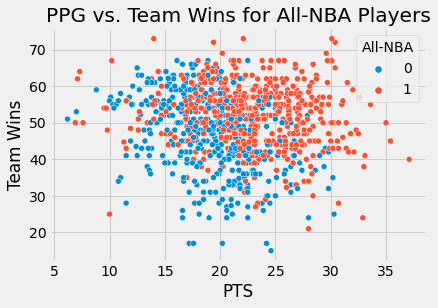

In [32]:
sns.scatterplot(x='PTS', y='Team Wins', hue='All-NBA',
                data=df_historical).set(title='PPG vs. Team Wins for All-NBA Players');

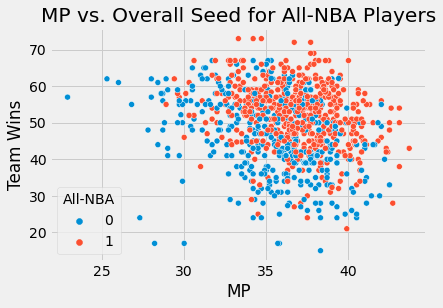

In [33]:
sns.scatterplot(x='MP', y='Team Wins', hue='All-NBA',
                data=df_historical).set(title='MP vs. Overall Seed for All-NBA Players');

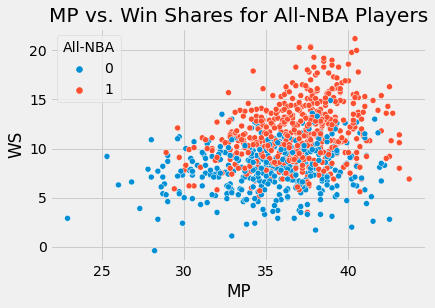

In [34]:
sns.scatterplot(x='MP', y='WS', hue='All-NBA',
                data=df_historical).set(title='MP vs. Win Shares for All-NBA Players');

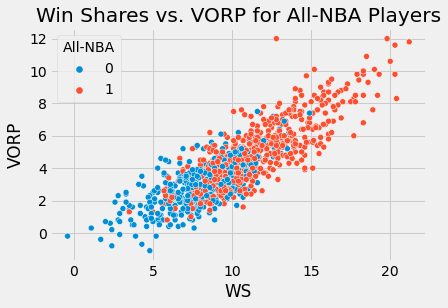

In [35]:
sns.scatterplot(x='WS', y='VORP', hue='All-NBA',
                data=df_historical).set(title='Win Shares vs. VORP for All-NBA Players');

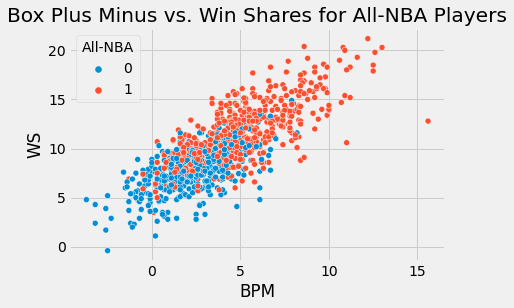

In [36]:
sns.scatterplot(x='BPM', y='WS', hue='All-NBA',
                data=df_historical).set(title='Box Plus Minus vs. Win Shares for All-NBA Players');

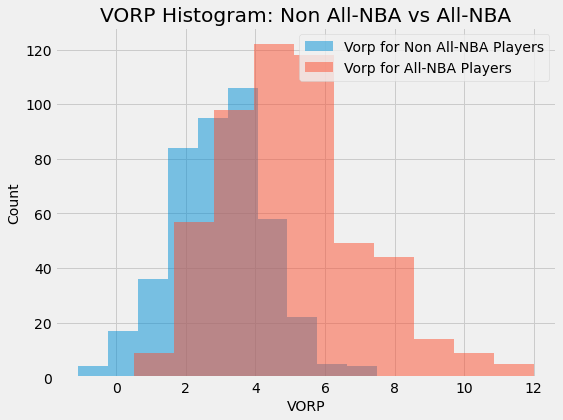

In [37]:
plt.figure(figsize=(8,6))
plt.hist(df_historical[df_historical['All-NBA'] == 0].VORP, alpha=0.50, label = 'Vorp for Non All-NBA Players')
plt.hist(df_historical[df_historical['All-NBA'] == 1].VORP, alpha=0.50, label = 'Vorp for All-NBA Players')

plt.xlabel("VORP", size=14)
plt.ylabel("Count", size=14)
plt.title("VORP Histogram: Non All-NBA vs All-NBA")
plt.legend(loc='best');

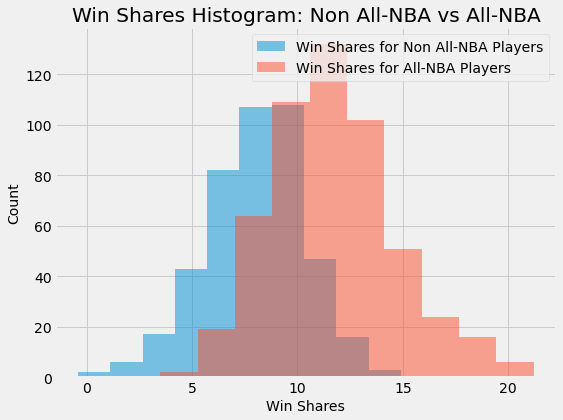

In [38]:
plt.figure(figsize=(8,6))
plt.hist(df_historical[df_historical['All-NBA'] == 0].WS, alpha=0.50, label = 'Win Shares for Non All-NBA Players')
plt.hist(df_historical[df_historical['All-NBA'] == 1].WS, alpha=0.50, label = 'Win Shares for All-NBA Players')

plt.xlabel("Win Shares", size=14)
plt.ylabel("Count", size=14)
plt.title("Win Shares Histogram: Non All-NBA vs All-NBA")
plt.legend(loc='best');

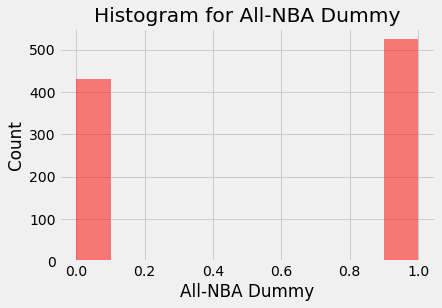

In [39]:
plt.hist(df_historical['All-NBA'], facecolor='red', alpha=0.50)
plt.xlabel('All-NBA Dummy')
plt.ylabel('Count')
plt.title('Histogram for All-NBA Dummy');

# Time to Create Classification Models

- Models I plan on using
    - Logistic regression
    - KNN classifier
    - Random forest classifier
    - Gradiant boosting classifier

In [40]:
# data seems to be balanced
round(df_historical['All-NBA'].sum()/df_historical.shape[0], 2)

0.55

- Data looks balanced. Even though the ratio of all-nba to non is 0.55, it's pretty close to 0.50. I will assume that the data is balanced

In [41]:
# splitting data
X = df_historical[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'VORP', 'WS', 'All-Star']]
y = df_historical['All-NBA']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24)

In [42]:
print(round(sum(y_train)/len(y_train),2),":",round(sum(y_test)/len(y_test),2))
print('Data is still pretty balanced in test set. Might be a bit over but it is okay in my book')

0.53 : 0.59
Data is still pretty balanced in test set. Might be a bit over but it is okay in my book


### I got this function below from Dribble Analytic's work. It seemed very convenient to use, I hope it's okay.

In [43]:
# Create function that gives accuracy scores for each model

def scores(model):
    
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    
    print("Accuracy score: %.3f" % metrics.accuracy_score(y_test, y_pred))
    print("Recall: %.3f" % metrics.recall_score(y_test, y_pred))
    print("Precision: %.3f" % metrics.precision_score(y_test, y_pred))
    print("F1: %.3f" % metrics.f1_score(y_test, y_pred))
    
    proba = model.predict_proba(X_test)

    pos_prob = proba[:, 1]
    print("Area under ROC curve: %.3f" % metrics.roc_auc_score(y_test, pos_prob))
    
    cv = cross_val_score(model, X_test, y_test.values.ravel(), cv = 5, scoring = 'accuracy')
    print("Accuracy (cross validation score): %0.3f (+/- %0.3f)" % (cv.mean(), cv.std() * 2))
    
    return y_pred

# Logistic Regression

In [44]:
# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


logit = LogisticRegression(random_state=24)
y_logit = scores(logit)

Accuracy score: 0.592
Recall: 1.000
Precision: 0.592
F1: 0.744
Area under ROC curve: 0.500
Accuracy (cross validation score): 0.816 (+/- 0.034)


/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logisti

# KNN Classifier

In [45]:
#Create a list to store the results
cvres=[]
# Run through various values for k: use 5-fold cross validation, score with accuracy
for i in range(1,100):
    clf = KNeighborsClassifier(n_neighbors=i)
    nn = cross_validate(clf, X_train, y_train, cv=5, scoring='accuracy')
    #The test score gives an list of the accuracy on each of the five the test-folds
    cvres.append(nn['test_score'].mean())

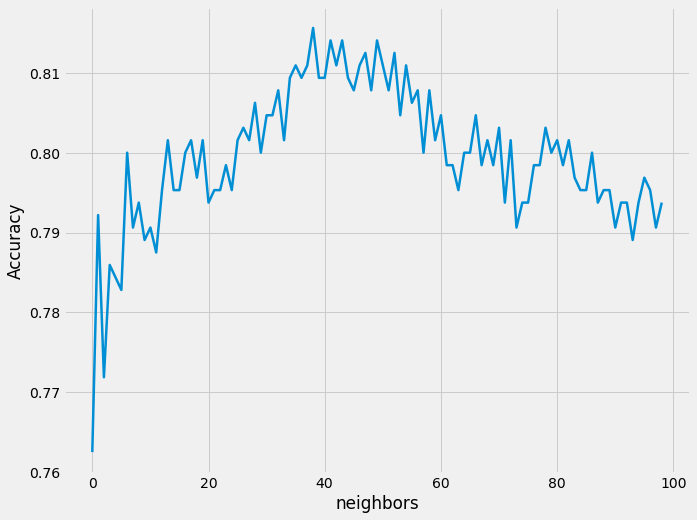

In [46]:
# plot to help determine n
plt.figure(figsize=(10, 8))
plt.plot(list(range(len(cvres))),cvres,linewidth=2.5)
plt.xlabel('neighbors')
plt.ylabel('Accuracy')
plt.show()

- n = 16 looks to be favorable because we have a solid accuracy score and a not so big n.

In [47]:
print(str(cvres[16]) + ': seems to be where our favorable n is.') 

0.8: seems to be where our favorable n is.


In [48]:
knn_clf = KNeighborsClassifier(n_neighbors=16)

y_knn = scores(knn_clf)

Accuracy score: 0.592
Recall: 1.000
Precision: 0.592
F1: 0.744
Area under ROC curve: 0.532
Accuracy (cross validation score): 0.772 (+/- 0.060)


/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


# Random Forest Classifier

In [49]:
# train test split
# calling this again to get rid of old X_train that was scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24)

In [50]:
rf_clf = RandomForestClassifier(n_estimators=400, max_features='sqrt', random_state=24)
y_rf = scores(rf_clf)

Accuracy score: 0.759
Recall: 0.765
Precision: 0.817
F1: 0.790
Area under ROC curve: 0.871
Accuracy (cross validation score): 0.785 (+/- 0.094)


# Gradient Boosting Classifier

In [51]:
# finding the best parameters for the model
parameters = {'learning_rate':[0.1,0.01], 'n_estimators':[300,400,500],'max_depth':[2,3,4,5]}
bmod = GradientBoostingClassifier(random_state=24)

boost_clf = GridSearchCV(bmod, parameters)
boost_clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=24),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [300, 400, 500]})

In [52]:
df = pd.DataFrame.from_dict(boost_clf.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.231805,0.000433,0.001137,0.000011,0.01,2,500,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.820312,0.8125,0.742188,0.835938,0.773438,0.796875,0.034233,1


In [53]:
best_bclf = GradientBoostingClassifier(random_state=24,
                                      learning_rate=0.01, n_estimators=500, max_depth=2)
y_boost = scores(best_bclf)

Accuracy score: 0.772
Recall: 0.775
Precision: 0.829
F1: 0.801
Area under ROC curve: 0.878
Accuracy (cross validation score): 0.779 (+/- 0.075)


# Confusion Matrix

In [54]:
def confusion_matrix(y_pred, model_name):
    cm = metrics.confusion_matrix(y_test, y_pred)

    plt.style.use("fivethirtyeight")
    z, ax = plt.subplots()

    sns.heatmap(cm, annot=True, ax = ax, linewidth = 2, fmt='g')

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    z.suptitle("%s Confusion Matrix" % model_name.upper(), weight = 'bold', size = 18, x = .45)

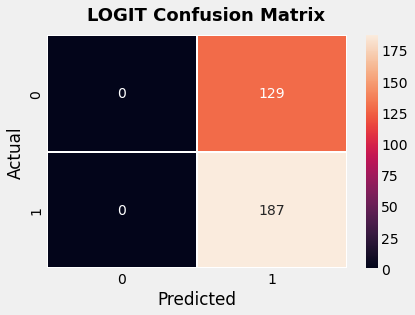

In [55]:
confusion_matrix(y_logit, 'Logit')

- Lol, Logistic is basically predicting all-nba for everyone

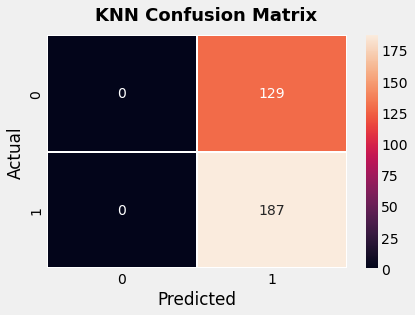

In [56]:
confusion_matrix(y_knn, 'KNN')

- Same with KNN, basically predicting everyone is an all-nba player lol

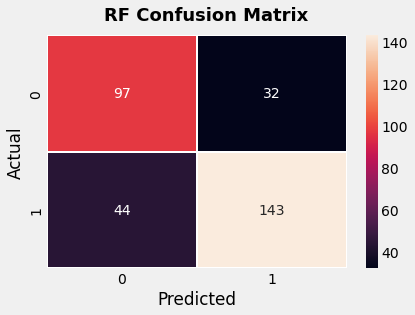

In [57]:
confusion_matrix(y_rf, 'RF')

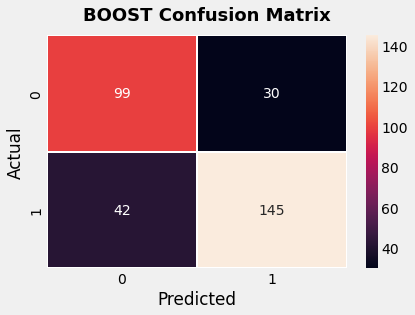

In [58]:
confusion_matrix(y_boost, 'Boost')

## Interpret the Confusion Matrix
- Seems like Logistic Regression and KNN classifier are the worst models.
    - They're basically predicting everyone is an all-nba player
        - has a high recall score aka high False Negatives
        - maybe the data was imbalanced towards all-nba
- the remaining two models perform well
    - Boosting, as usual, is the best model. Has a solid F-1 Score

# ROC Curves

In [59]:
def roc_curve(model):

    proba = model.predict_proba(X_test)
    pos_prob = proba[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, pos_prob)
    
    return (fpr, tpr, pos_prob)

/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


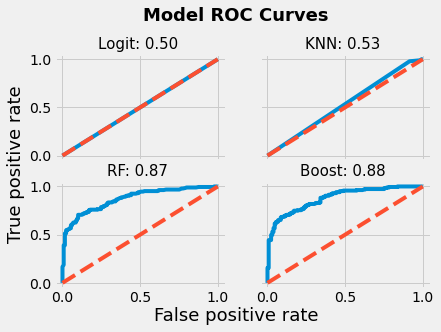

In [60]:
plt.style.use('fivethirtyeight')

roc, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey = True, sharex = True)

fpr, tpr, pos_prob = roc_curve(logit)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], linestyle = '--')
ax1.set_title("Logit: %.2f" % metrics.roc_auc_score(y_test, pos_prob), size = 15, x = .485, ha = 'center')

fpr, tpr, pos_prob = roc_curve(knn_clf)
ax2.plot(fpr, tpr)
ax2.plot([0, 1], [0, 1], linestyle = '--')
ax2.set_title("KNN: %.2f" % metrics.roc_auc_score(y_test, pos_prob), size = 15, x = .485, ha = 'center')

fpr, tpr, pos_prob = roc_curve(rf_clf)
ax3.plot(fpr, tpr)
ax3.plot([0, 1], [0, 1], linestyle = '--')
ax3.set_title("RF: %.2f" % metrics.roc_auc_score(y_test, pos_prob), size = 15, x = .485, ha = 'center')

fpr, tpr, pos_prob = roc_curve(boost_clf)
ax4.plot(fpr, tpr)
ax4.plot([0, 1], [0, 1], linestyle = '--')
ax4.set_title("Boost: %.2f" % metrics.roc_auc_score(y_test, pos_prob), size = 15, x = .485, ha = 'center')

roc.text(-0.03, 0.5, "True positive rate", va='center', rotation='vertical', size = 18)
roc.text(0.5, -0.045, "False positive rate", ha = 'center', size = 18)

roc.suptitle("Model ROC Curves", y = 1.045, weight = 'bold', size = 18);

# Prediction

In [61]:
# using only the top 75 players
df_2022_names = df_full_2022['Player'][:75]
df_2022_predict = df_full_2022[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'VORP', 'WS', 'All-Star']][:75]

In [62]:
# function to make predictions for our current 2022 dataset
def make_pred(model):

    proba = model.predict_proba(df_2022_predict)
    pos_prob = proba[:, 1]
    
    combined_list = [[i, j] for i, j in zip(df_2022_names, pos_prob)]
    combined_list = sorted(combined_list, key = itemgetter(1), reverse = True)
    
    for i in combined_list:
        print(i)
        
    return pos_prob

In [63]:
# getting the top 25
logit_prob = make_pred(logit)[:25]

['Nikola Jokić\\jokicni01', 1.0]
['Giannis Antetokounmpo\\antetgi01', 1.0]
['Joel Embiid\\embiijo01', 1.0]
['Rudy Gobert\\goberru01', 1.0]
['Karl-Anthony Towns\\townska01', 1.0]
['Trae Young\\youngtr01', 1.0]
['Robert Williams\\williro04', 1.0]
['Jayson Tatum\\tatumja01', 1.0]
['Chris Paul\\paulch01', 1.0]
['Jimmy Butler\\butleji01', 1.0]
['Mikal Bridges\\bridgmi01', 1.0]
['DeMar DeRozan\\derozde01', 1.0]
['Jarrett Allen\\allenja01', 1.0]
['Mitchell Robinson\\robinmi01', 1.0]
['Kevin Durant\\duranke01', 1.0]
['Clint Capela\\capelca01', 1.0]
['Dwight Powell\\poweldw01', 1.0]
['Pascal Siakam\\siakapa01', 1.0]
['Stephen Curry\\curryst01', 1.0]
['Al Horford\\horfoal01', 1.0]
['James Harden\\hardeja01', 1.0]
['Devin Booker\\bookede01', 1.0]
['Luka Dončić\\doncilu01', 1.0]
['Jalen Brunson\\brunsja01', 1.0]
['LeBron James\\jamesle01', 1.0]
['Montrezl Harrell\\harremo01', 1.0]
['Dejounte Murray\\murrade01', 1.0]
['Tyrese Maxey\\maxeyty01', 1.0]
['Deandre Ayton\\aytonde01', 1.0]
['Jonas Valanči

/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [64]:
knn_prob = make_pred(knn_clf)[:25]

['Nikola Jokić\\jokicni01', 1.0]
['Giannis Antetokounmpo\\antetgi01', 1.0]
['Joel Embiid\\embiijo01', 1.0]
['Rudy Gobert\\goberru01', 1.0]
['Karl-Anthony Towns\\townska01', 1.0]
['Trae Young\\youngtr01', 1.0]
['Robert Williams\\williro04', 1.0]
['Jayson Tatum\\tatumja01', 1.0]
['Chris Paul\\paulch01', 1.0]
['Jimmy Butler\\butleji01', 1.0]
['Mikal Bridges\\bridgmi01', 1.0]
['DeMar DeRozan\\derozde01', 1.0]
['Jarrett Allen\\allenja01', 1.0]
['Mitchell Robinson\\robinmi01', 1.0]
['Kevin Durant\\duranke01', 1.0]
['Clint Capela\\capelca01', 1.0]
['Dwight Powell\\poweldw01', 1.0]
['Pascal Siakam\\siakapa01', 1.0]
['Stephen Curry\\curryst01', 1.0]
['Al Horford\\horfoal01', 1.0]
['James Harden\\hardeja01', 1.0]
['Devin Booker\\bookede01', 1.0]
['Luka Dončić\\doncilu01', 1.0]
['Jalen Brunson\\brunsja01', 1.0]
['LeBron James\\jamesle01', 1.0]
['Montrezl Harrell\\harremo01', 1.0]
['Dejounte Murray\\murrade01', 1.0]
['Tyrese Maxey\\maxeyty01', 1.0]
['Deandre Ayton\\aytonde01', 1.0]
['Jonas Valanči

/Users/oscaralonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [65]:
rf_prob = make_pred(rf_clf)[:25]

['Nikola Jokić\\jokicni01', 0.9975]
['Giannis Antetokounmpo\\antetgi01', 0.9825]
['Joel Embiid\\embiijo01', 0.9625]
['Luka Dončić\\doncilu01', 0.8675]
['Karl-Anthony Towns\\townska01', 0.83]
['Rudy Gobert\\goberru01', 0.815]
['Pascal Siakam\\siakapa01', 0.805]
['James Harden\\hardeja01', 0.79]
['Kevin Durant\\duranke01', 0.765]
['Jayson Tatum\\tatumja01', 0.75]
['Stephen Curry\\curryst01', 0.7425]
['Jaylen Brown\\brownja02', 0.7275]
['Bam Adebayo\\adebaba01', 0.7225]
['Ja Morant\\moranja01', 0.645]
['Mikal Bridges\\bridgmi01', 0.63]
['Jrue Holiday\\holidjr01', 0.63]
['Al Horford\\horfoal01', 0.6275]
['Desmond Bane\\banede01', 0.6275]
['Deandre Ayton\\aytonde01', 0.62]
['Dejounte Murray\\murrade01', 0.615]
['DeMar DeRozan\\derozde01', 0.6125]
['Mike Conley\\conlemi01', 0.61]
['Steven Adams\\adamsst01', 0.605]
['Robert Williams\\williro04', 0.5975]
['Montrezl Harrell\\harremo01', 0.5975]
['Clint Capela\\capelca01', 0.595]
['Miles Bridges\\bridgmi02', 0.595]
['Kyle Lowry\\lowryky01', 0.59

In [66]:
boost_prob = make_pred(best_bclf)[:25]

['Nikola Jokić\\jokicni01', 0.9648248446507913]
['Giannis Antetokounmpo\\antetgi01', 0.9588644742083678]
['Joel Embiid\\embiijo01', 0.9352103672942907]
['James Harden\\hardeja01', 0.900784314554156]
['Pascal Siakam\\siakapa01', 0.872871958959654]
['Karl-Anthony Towns\\townska01', 0.832876277554534]
['Luka Dončić\\doncilu01', 0.8262845801442046]
['Trae Young\\youngtr01', 0.775002574425765]
['Jaylen Brown\\brownja02', 0.7676368771704943]
['Domantas Sabonis\\sabondo01', 0.7590837803935772]
['Domantas Sabonis\\sabondo01', 0.7590837803935772]
['Clint Capela\\capelca01', 0.7533025502183154]
['Jayson Tatum\\tatumja01', 0.746388303108436]
['Stephen Curry\\curryst01', 0.7345591932646008]
['Jonas Valančiūnas\\valanjo01', 0.72287041544283]
['Kevin Durant\\duranke01', 0.7209597168426369]
['Bam Adebayo\\adebaba01', 0.7162351601991305]
['DeMar DeRozan\\derozde01', 0.6746724242257908]
['Rudy Gobert\\goberru01', 0.6727554705523333]
['LeBron James\\jamesle01', 0.672273489568357]
['Deandre Ayton\\aytond

In [67]:
# finding the average probability for each model
# will leave out logistic regression and RF since they're not good models
avg_prob = []

for i, j  in zip(rf_prob, boost_prob):
    avg_prob.append((i + j) / 2)
    
avg_list = [[i, j] for i, j in zip(df_2022_names, avg_prob)]
avg_list = sorted(avg_list, key = itemgetter(1), reverse = True)

for i in avg_list:
    print(i)

['Nikola Jokić\\jokicni01', 0.9811624223253956]
['Giannis Antetokounmpo\\antetgi01', 0.9706822371041839]
['Joel Embiid\\embiijo01', 0.9488551836471454]
['Luka Dončić\\doncilu01', 0.8468922900721023]
['James Harden\\hardeja01', 0.845392157277078]
['Pascal Siakam\\siakapa01', 0.838935979479827]
['Karl-Anthony Towns\\townska01', 0.8314381387772669]
['Jayson Tatum\\tatumja01', 0.748194151554218]
['Rudy Gobert\\goberru01', 0.7438777352761666]
['Kevin Durant\\duranke01', 0.7429798584213185]
['Stephen Curry\\curryst01', 0.7385295966323004]
['Trae Young\\youngtr01', 0.6812512872128825]
['Clint Capela\\capelca01', 0.6741512751091576]
['DeMar DeRozan\\derozde01', 0.6435862121128955]
['Mikal Bridges\\bridgmi01', 0.6192112816052338]
['LeBron James\\jamesle01', 0.6086367447841785]
['Devin Booker\\bookede01', 0.6028854728522395]
['Robert Williams\\williro04', 0.6014363846142137]
['Jalen Brunson\\brunsja01', 0.5805087763723059]
['Al Horford\\horfoal01', 0.5773624887717643]
['Dwight Powell\\poweldw01'

In [68]:
avg_list[:17]

[['Nikola Jokić\\jokicni01', 0.9811624223253956],
 ['Giannis Antetokounmpo\\antetgi01', 0.9706822371041839],
 ['Joel Embiid\\embiijo01', 0.9488551836471454],
 ['Luka Dončić\\doncilu01', 0.8468922900721023],
 ['James Harden\\hardeja01', 0.845392157277078],
 ['Pascal Siakam\\siakapa01', 0.838935979479827],
 ['Karl-Anthony Towns\\townska01', 0.8314381387772669],
 ['Jayson Tatum\\tatumja01', 0.748194151554218],
 ['Rudy Gobert\\goberru01', 0.7438777352761666],
 ['Kevin Durant\\duranke01', 0.7429798584213185],
 ['Stephen Curry\\curryst01', 0.7385295966323004],
 ['Trae Young\\youngtr01', 0.6812512872128825],
 ['Clint Capela\\capelca01', 0.6741512751091576],
 ['DeMar DeRozan\\derozde01', 0.6435862121128955],
 ['Mikal Bridges\\bridgmi01', 0.6192112816052338],
 ['LeBron James\\jamesle01', 0.6086367447841785],
 ['Devin Booker\\bookede01', 0.6028854728522395]]

# Results: Table of predicted 2022 All-NBA Teams

| Player | Position | All-NBA Team
| --- | ----------- | ---
| James Harden | Guard | 1
| Luka Dončić | Guard | 1
| Giannis Antetokounmpo | Forward | 1
| Pascal Siakam | Forward | 1
| Nikola Jokić | Center | 1
|Stephen Curry | Guard | 2
| Trae Young | Guard | 2
| Jayson Tatum | Forward | 2
| Karl-Anthony Towns | Forward | 2
| Joel Embiid | Center | 2
| Devin Booker | Guard | 3
| DeMar DeRozan | Guard | 3
| Mikal Bridges | Forward | 3
| Kevin Durant | Forward | 3
| Rudy Gobert | Center | 3

- Sucks that Joel Embiid has to be in the 2nd team because of the format.
    - Jokic and Embiid are both centers and had great seasons. Only one spot for center per team though :-(
- No Lebron in here, wow.
- Pascal Siakam is high, a bit too high 🤔
- **Hopefully the results of avg_list don't change the table when other people run this.**
- 2nd team all-nba might beat the other two teams, they're really good
- James Harden may have gotten a boost
    - He got traded from a 44 win team to a 51 win team

### Thanks for all the lecures professor, I really appreciated the class!! Hopefully this notebook isn't too messy!